In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib
import statistics
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import math
import glob
from itertools import combinations
from matplotlib import pyplot as plt
from Bio import Phylo
import biotite
from pca_plot import *
from stattools.resampling import PermutationTest
from matplotlib_venn import venn2

In [23]:
chm13 = pd.read_csv('/Users/luciabazan/Downloads/chm13_gene_regions.csv', index_col=0)
chm13['LENGHT'] = chm13['END'] - chm13['START']
chm13 = chm13.drop(columns=['START_GENE', 'END_GENE'])
chm13 = chm13.drop_duplicates()
#chm13 = chm13[chm13['SCORE'] < 5]
chm13#['TYPE'].value_counts()

,SAMPLE,CHR,START,END,SCORE,TYPE,LENGHT
0,LP6005441-DNA_B02,chrX,105118,116978,1,DELETION,11860
18,LP6005441-DNA_B02,chrX,1038532,1048096,1,DELETION,9564
21,LP6005441-DNA_B02,chrX,1193541,1202443,1,DELETION,8902
24,LP6005441-DNA_B02,chrX,1296349,1304923,1,DELETION,8574
26,LP6005441-DNA_B02,chrX,1855267,1863572,1,DELETION,8305
...,...,...,...,...,...,...,...
1874421,LP6005442-DNA_H01,chr1,247606647,247620901,5,DUPLICATION,14254
1874427,LP6005442-DNA_H01,chr1,247629795,247637933,4,DUPLICATION,8138
1874430,LP6005442-DNA_H01,chr1,247738073,247750886,6,DUPLICATION,12813
1874432,LP6005442-DNA_H01,chr1,247954331,247967419,4,DUPLICATION,13088


In [24]:
## Read and merge files 
anotation = pd.read_csv('../data/SGDP_anotation.csv', sep=',', encoding='latin-1')

ids_hg19 = pd.DataFrame()
ids_hg19['SAMPLE'] = anotation['3-Illumina_ID']
ids_hg19['REGION'] = anotation['10-Region']
ids_hg19['COUNTRY'] = anotation['11-Country']

In [25]:
#change to df when using telomeres and centromeres filtration
cnv = chm13.pivot_table(index=["CHR", "START", "END"], 
                    columns='SAMPLE', 
                    values='SCORE').reset_index()


cnv

SAMPLE,CHR,START,END,LP6005441-DNA_A01,LP6005441-DNA_A03,LP6005441-DNA_A04,LP6005441-DNA_A05,LP6005441-DNA_A06,LP6005441-DNA_A08,LP6005441-DNA_A09,...,LP6005677-DNA_D03,LP6005677-DNA_E01,LP6005677-DNA_F01,LP6005677-DNA_G01,LP6007068-DNA_A01,LP6007069-DNA_A01,SS6004471,SS6004477,SS6004478,SS6004480
0,chr1,102061,111943,12.0,15.0,11.0,14.0,15.0,12.0,11.0,...,15.0,13.0,14.0,14.0,14.0,12.0,15.0,11.0,13.0,16.0
1,chr1,521722,540598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0
2,chr1,613436,625116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,839350,851555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
4,chr1,1041679,1050074,NaN,NaN,1.0,1.0,NaN,1.0,NaN,...,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10743,chrY,26436587,26458551,5.0,0.0,0.0,4.0,4.0,3.0,NaN,...,0.0,4.0,0.0,4.0,4.0,0.0,3.0,4.0,0.0,4.0
10744,chrY,26778516,26788355,4.0,0.0,0.0,3.0,3.0,4.0,NaN,...,0.0,3.0,0.0,4.0,4.0,0.0,3.0,3.0,0.0,4.0
10745,chrY,62325695,62345374,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10746,chrY,62345374,62363313,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
coordinates = cnv.iloc[:,0:2]
cnvs = cnv.iloc[:,3:284]
cnvs = cnvs.T
cnvs = cnvs.fillna(2)
cnvs

,0,1,2,3,4,5,6,7,8,9,...,10738,10739,10740,10741,10742,10743,10744,10745,10746,10747
SAMPLE,,,,,,,,,,,,,,,,,,,,,
LP6005441-DNA_A01,12.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,...,3.0,4.0,4.0,4.0,3.0,5.0,4.0,2.0,2.0,2.0
LP6005441-DNA_A03,15.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0
LP6005441-DNA_A04,11.0,2.0,2.0,2.0,1.0,3.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0
LP6005441-DNA_A05,14.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,...,2.0,3.0,3.0,3.0,2.0,4.0,3.0,2.0,2.0,2.0
LP6005441-DNA_A06,15.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,...,2.0,3.0,3.0,3.0,3.0,4.0,3.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LP6007069-DNA_A01,12.0,2.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0
SS6004471,15.0,1.0,2.0,2.0,1.0,3.0,1.0,2.0,2.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0
SS6004477,11.0,2.0,2.0,2.0,2.0,3.0,1.0,2.0,2.0,2.0,...,2.0,3.0,3.0,4.0,3.0,4.0,3.0,2.0,2.0,2.0


In [40]:
dt = ids_hg19.set_index('SAMPLE').merge(cnvs, left_index=True, right_index=True)
dt = dt.sort_index()
features = dt.loc[:,['REGION', 'COUNTRY']]
features = features.sort_index()

In [41]:
####### Groupby regions #######
dt_group = dt.groupby('REGION')

dt_groupped = []
regions = features['REGION'].unique()
print(regions)
for i in regions:
    dt_groupped.append(dt_group.get_group(str(i)))
    

#### Names to pair-population
regions = dt['REGION'].unique()
print(regions)
combination_names = []
for i in list(combinations(regions,2)):
    combination_names.append(i[0]+str('-')+i[1])
    


['WestEurasia' 'Oceania' 'America' 'Africa' 'EastAsia' 'SouthAsia'
 'CentralAsiaSiberia']
['WestEurasia' 'Oceania' 'America' 'Africa' 'EastAsia' 'SouthAsia'
 'CentralAsiaSiberia']


In [42]:
####### Groupby regions #######
dt_group = dt.groupby('REGION')

dt_groupped = []
regions = features['REGION'].unique()
for i in regions:
    dt_groupped.append(dt_group.get_group(str(i)))
    

#### Names to pair-population
regions = dt['REGION'].unique()
combination_names = []
for i in list(combinations(regions,2)):
    combination_names.append(i[0]+str('-')+i[1])
    


In [43]:
dt_groupped

[                        REGION           COUNTRY     0    1    2    3    4  \
 SAMPLE                                                                       
 LP6005441-DNA_A01  WestEurasia  Russia(Caucasus)  12.0  2.0  2.0  2.0  2.0   
 LP6005441-DNA_A05  WestEurasia            France  14.0  2.0  2.0  2.0  1.0   
 LP6005441-DNA_A06  WestEurasia    Italy(Bergamo)  15.0  2.0  2.0  2.0  2.0   
 LP6005441-DNA_B01  WestEurasia  Russia(Caucasus)  15.0  2.0  2.0  2.0  2.0   
 LP6005441-DNA_B05  WestEurasia            France  16.0  2.0  2.0  2.0  2.0   
 ...                        ...               ...   ...  ...  ...  ...  ...   
 LP6005677-DNA_A03  WestEurasia            Turkey  13.0  2.0  2.0  2.0  1.0   
 LP6005677-DNA_B01  WestEurasia           Albania  14.0  1.0  2.0  2.0  1.0   
 LP6005677-DNA_C03  WestEurasia            Turkey  15.0  2.0  2.0  2.0  2.0   
 LP6007068-DNA_A01  WestEurasia            Greece  14.0  2.0  2.0  2.0  1.0   
 LP6007069-DNA_A01  WestEurasia            Greece  1

In [44]:
## VST for pair-population

from vst_function import *
vst_dt = []

combination_regions = list(combinations([0,1,2,3,4,5,6],2))
for region in combination_regions:
        statistic = vst((dt_groupped[region[0]]), (dt_groupped[region[1]]))
        vst_dt.append(statistic)

vst_dt = pd.DataFrame(vst_dt).set_axis(combination_names)
#vst_dt = vst_dt.T
vst_dt

/Users/luciabazan/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3721: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/luciabazan/GitHub/cnv_sgdp/scripts/vst_function.py:33: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vt = pd.concat([x,y]).var()
/Users/luciabazan/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3721: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return var(ax

/Users/luciabazan/GitHub/cnv_sgdp/scripts/vst_function.py:33: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vt = pd.concat([x,y]).var()
/Users/luciabazan/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3721: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/luciabazan/GitHub/cnv_sgdp/scripts/vst_function.py:33: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vt = pd.concat([x,y]).var()
/Users/luciabaz

,0,1,2,3,4,5,6,7,8,9,...,10738,10739,10740,10741,10742,10743,10744,10745,10746,10747
WestEurasia-Oceania,0.018341,0.051059,NaN,0.011431,0.032919,0.211830,0.018174,0.026963,0.013699,NaN,...,0.011049,0.014368,0.010634,0.010957,0.013532,0.015718,0.016524,0.013699,0.013699,0.017159
WestEurasia-America,0.030527,0.011290,NaN,0.034343,0.011314,0.010878,0.015387,0.015938,0.013699,NaN,...,0.019031,0.037490,0.029717,0.025666,0.033569,0.032367,0.053015,0.013699,0.013699,0.016709
WestEurasia-Africa,0.106892,0.026284,NaN,0.035764,0.009836,0.008914,0.012906,0.012066,0.013699,0.040287,...,0.016610,0.012335,0.016269,0.014630,0.009739,0.009910,0.013250,0.013699,0.013699,0.018713
WestEurasia-EastAsia,0.053486,0.008431,0.021739,0.010159,0.016229,0.013078,0.008636,0.008846,0.013699,0.021739,...,0.017906,0.017626,0.021756,0.020667,0.032477,0.022732,0.020829,0.009323,0.009323,0.008710
WestEurasia-SouthAsia,0.139888,0.009650,NaN,0.016641,0.031034,0.011604,0.036289,0.009065,0.045439,0.026316,...,0.045856,0.034583,0.034854,0.034127,0.034310,0.027913,0.044059,0.013699,0.011016,0.009019
WestEurasia-CentralAsiaSiberia,0.045162,0.026437,NaN,0.024486,0.026242,0.011974,0.028864,0.011155,0.013699,NaN,...,0.068812,0.052202,0.085663,0.088231,0.070584,0.055544,0.052083,0.061000,0.061000,0.017473
Oceania-America,0.027853,0.058375,NaN,0.078571,0.068333,0.258437,0.059375,0.083034,NaN,NaN,...,0.028203,0.038188,0.041869,0.034977,0.036940,0.032124,0.048885,NaN,NaN,NaN
Oceania-Africa,0.177461,0.022490,NaN,0.053179,0.035647,0.291658,0.016585,0.025474,NaN,0.033682,...,0.028906,0.032129,0.026887,0.026288,0.024735,0.029184,0.038507,NaN,NaN,NaN
Oceania-EastAsia,0.027726,0.063124,0.021739,NaN,0.022091,0.229167,0.028340,0.041079,NaN,0.021739,...,0.018641,0.014933,0.023273,0.020600,0.023021,0.015739,0.014851,0.021739,0.021739,0.021739
Oceania-SouthAsia,0.105252,0.076120,NaN,0.036842,0.112390,0.208019,0.021033,0.037718,0.036842,0.026316,...,0.068615,0.073444,0.052900,0.052606,0.071957,0.072104,0.095339,NaN,0.026316,0.026316


In [45]:
filtering_vst = pd.DataFrame(vst_dt)>=0.2
filtering_vst = filtering_vst.loc[:, filtering_vst.any()]
#filtering_vst = filtering_vst.set_axis(combination_names)
filtering_vst

,0,5,30,35,52,62,63,76,81,101,...,10722,10723,10733,10734,10735,10736,10737,10738,10740,10741
WestEurasia-Oceania,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-America,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-Africa,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-EastAsia,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-SouthAsia,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-CentralAsiaSiberia,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
Oceania-America,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Oceania-Africa,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Oceania-EastAsia,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Oceania-SouthAsia,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [46]:
## Coordinates anotation 
vst_dt = vst_dt.T
vst_dt.insert (0, 'CHR', cnv['CHR'])
vst_dt.insert (1, 'START', cnv['START'])
vst_dt.insert (2, 'END', cnv['END'])
vst_dt = vst_dt.round(5)
vst_dt = vst_dt.replace(np.NaN, 0)
vst_dt

,CHR,START,END,WestEurasia-Oceania,WestEurasia-America,WestEurasia-Africa,WestEurasia-EastAsia,WestEurasia-SouthAsia,WestEurasia-CentralAsiaSiberia,Oceania-America,...,America-Africa,America-EastAsia,America-SouthAsia,America-CentralAsiaSiberia,Africa-EastAsia,Africa-SouthAsia,Africa-CentralAsiaSiberia,EastAsia-SouthAsia,EastAsia-CentralAsiaSiberia,SouthAsia-CentralAsiaSiberia
0,chr1,102061,111943,0.01834,0.03053,0.10689,0.05349,0.13989,0.04516,0.02785,...,0.22796,0.01875,0.08211,0.02384,0.25003,0.38865,0.27465,0.04123,0.01440,0.06735
1,chr1,521722,540598,0.05106,0.01129,0.02628,0.00843,0.00965,0.02644,0.05837,...,0.02602,0.01610,0.02000,0.03295,0.03112,0.03811,0.01472,0.01236,0.03382,0.04249
2,chr1,613436,625116,0.00000,0.00000,0.00000,0.02174,0.00000,0.00000,0.00000,...,0.00000,0.02174,0.00000,0.00000,0.02174,0.00000,0.00000,0.02174,0.02174,0.00000
3,chr1,839350,851555,0.01143,0.03434,0.03576,0.01016,0.01664,0.02449,0.07857,...,0.01641,0.08594,0.02500,0.02334,0.06494,0.01975,0.01632,0.04108,0.06103,0.01729
4,chr1,1041679,1050074,0.03292,0.01131,0.00984,0.01623,0.03103,0.02624,0.06833,...,0.01992,0.02805,0.03106,0.03323,0.01485,0.04769,0.04425,0.07140,0.06552,0.01557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10743,chrY,26436587,26458551,0.01572,0.03237,0.00991,0.02273,0.02791,0.05554,0.03212,...,0.05240,0.01880,0.10031,0.02318,0.03634,0.02508,0.08474,0.08454,0.02798,0.15662
10744,chrY,26778516,26788355,0.01652,0.05302,0.01325,0.02083,0.04406,0.05208,0.04888,...,0.09490,0.03142,0.17249,0.02172,0.04330,0.02843,0.09200,0.10247,0.02697,0.17179
10745,chrY,62325695,62345374,0.01370,0.01370,0.01370,0.00932,0.01370,0.06100,0.00000,...,0.00000,0.02174,0.00000,0.05015,0.02174,0.00000,0.05539,0.02174,0.06351,0.05485
10746,chrY,62345374,62363313,0.01370,0.01370,0.01370,0.00932,0.01102,0.06100,0.00000,...,0.00000,0.02174,0.02632,0.05015,0.02174,0.02632,0.05539,0.01213,0.06351,0.06481


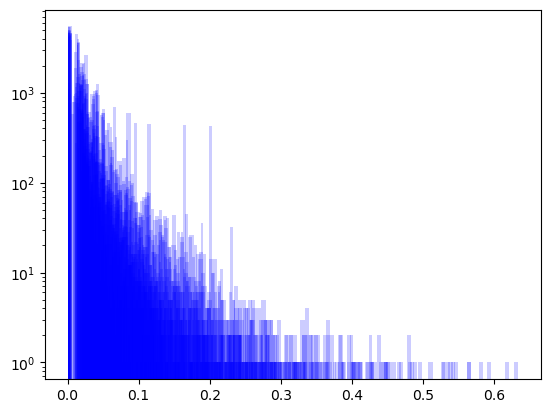

In [47]:
#sns.set_palette("bright")
for i in vst_dt.iloc[:,3:25].columns:
    plt.hist(vst_dt[i], bins=100, alpha=0.2, log=True, color="blue")

In [48]:
vst_dt[vst_dt.CHR== 'chr8'].sort_values(by=['WestEurasia-Oceania', 'START'],ascending=False).head(50)

#chr8	23424961	23435696

,CHR,START,END,WestEurasia-Oceania,WestEurasia-America,WestEurasia-Africa,WestEurasia-EastAsia,WestEurasia-SouthAsia,WestEurasia-CentralAsiaSiberia,Oceania-America,...,America-Africa,America-EastAsia,America-SouthAsia,America-CentralAsiaSiberia,Africa-EastAsia,Africa-SouthAsia,Africa-CentralAsiaSiberia,EastAsia-SouthAsia,EastAsia-CentralAsiaSiberia,SouthAsia-CentralAsiaSiberia
9157,chr8,23424961,23435696,0.34639,0.01370,0.09504,0.00932,0.01370,0.01370,0.29419,...,0.07859,0.02174,0.00000,0.00000,0.07698,0.10163,0.08916,0.02174,0.02174,0.00000
9505,chr8,144767201,144782295,0.32043,0.02486,0.01142,0.18178,0.02898,0.12367,0.21463,...,0.02226,0.07992,0.01735,0.06357,0.13755,0.02077,0.09951,0.08814,0.01988,0.05684
9365,chr8,88377645,88386330,0.11454,0.05417,0.02844,0.01128,0.01461,0.01113,0.24807,...,0.11332,0.06141,0.06272,0.07939,0.04913,0.05792,0.04226,0.01260,0.01398,0.01729
9140,chr8,19032169,19052143,0.10041,0.01349,0.00885,0.01676,0.01310,0.01062,0.07431,...,0.02088,0.01600,0.01727,0.02226,0.02085,0.01804,0.01603,0.01260,0.01722,0.01671
9273,chr8,56432862,56447376,0.09498,0.01170,0.03411,0.00844,0.01984,0.17676,0.11785,...,0.04412,0.01600,0.03317,0.18202,0.03845,0.01559,0.08259,0.02442,0.18735,0.11342
9314,chr8,68584437,68594990,0.09477,0.01076,0.02029,0.06451,0.00988,0.01346,0.15176,...,0.02726,0.07005,0.01800,0.02577,0.03048,0.01929,0.04523,0.05941,0.10815,0.02452
9499,chr8,142577933,142586954,0.07837,0.01998,0.01812,0.03695,0.01847,0.03864,0.17972,...,0.06621,0.08943,0.07249,0.02621,0.01967,0.01266,0.11478,0.02063,0.14452,0.12500
9130,chr8,16481751,16494016,0.07729,0.01337,0.00912,0.01676,0.01964,0.01273,0.06616,...,0.01789,0.01601,0.01906,0.03578,0.01673,0.02007,0.02056,0.01208,0.03308,0.03970
9111,chr8,8393710,8407139,0.07560,0.02125,0.02330,0.02149,0.01562,0.06737,0.05547,...,0.01640,0.01536,0.02098,0.04552,0.01165,0.01606,0.04366,0.01400,0.04708,0.06537
9196,chr8,39447636,39463249,0.07368,0.00000,0.00000,0.00000,0.04394,0.00000,0.06151,...,0.00000,0.00000,0.03571,0.00000,0.00000,0.04033,0.00000,0.04108,0.00000,0.03759


In [49]:
permutation_results = pd.read_csv("permutation_chm13_gene_regions.csv",index_col='Unnamed: 0')
permutation_results

,0,1,2,3,4,5,6,7,8,9,...,10738,10739,10740,10741,10742,10743,10744,10745,10746,10747
WestEurasia-Oceania,0.3793,0.0280,0.0001,0.8140,0.1202,0.0001,0.3759,0.2829,0.4171,0.0001,...,0.8182,0.5629,0.8153,0.7986,0.5914,0.4550,0.4182,1.0000,1.0000,0.6259
WestEurasia-America,0.1820,0.9143,0.0001,0.1497,0.9669,0.9753,0.4336,0.7236,0.7389,0.0001,...,0.3583,0.1203,0.1750,0.2595,0.1446,0.1745,0.0499,1.0000,1.0000,0.5739
WestEurasia-Africa,0.0008,0.1420,0.0001,0.0501,0.7816,0.9989,0.5902,0.4835,0.4373,0.0807,...,0.3553,0.5354,0.3764,0.4500,0.7651,0.7477,0.5067,0.9182,0.9238,0.5247
WestEurasia-EastAsia,0.0185,0.9992,0.2731,0.6084,0.2827,0.4773,0.8467,1.0000,0.8004,0.2665,...,0.2974,0.2754,0.2097,0.2474,0.0836,0.2065,0.2340,0.9256,0.9244,0.6225
WestEurasia-SouthAsia,0.0005,0.7566,0.0001,0.4826,0.1429,0.7589,0.1025,0.9730,0.0174,0.3476,...,0.0390,0.1056,0.0907,0.1008,0.1058,0.1433,0.0532,0.8419,0.8430,0.9694
WestEurasia-CentralAsiaSiberia,0.0582,0.2051,0.0001,0.2790,0.2265,0.7238,0.1521,0.6567,0.7623,0.0001,...,0.0169,0.0422,0.0061,0.0041,0.0141,0.0328,0.0419,0.0508,0.0547,0.5823
Oceania-America,0.6592,0.3324,0.0001,0.1472,0.2686,0.0024,0.2534,0.0947,0.0001,0.0001,...,0.5947,0.4555,0.3697,0.4722,0.4524,0.5211,0.2948,0.0001,0.0001,0.0001
Oceania-Africa,0.0007,0.5807,0.0001,0.2379,0.3356,0.0001,0.9861,0.5129,0.0001,0.5301,...,0.3986,0.3344,0.4028,0.4172,0.4446,0.3346,0.2260,0.0001,0.0001,0.0001
Oceania-EastAsia,0.3709,0.0689,0.8111,0.0001,0.5154,0.0003,0.3409,0.2565,0.0001,0.7966,...,0.5630,0.8614,0.4597,0.5532,0.4659,0.7511,0.8815,0.5750,0.5597,0.5715
Oceania-SouthAsia,0.0209,0.0710,0.0001,0.3888,0.0221,0.0008,0.7562,0.2881,0.4050,1.0000,...,0.0751,0.0506,0.1266,0.1278,0.0809,0.0626,0.0250,0.0001,1.0000,1.0000


In [264]:
boolean = (permutation_results<=0.05)


## Deleting columns where none of the regions passed the imputation
boolean = boolean.loc[:, boolean.any()]

In [265]:
boolean.columns = boolean.columns.astype(int)

In [198]:
# VST with permutation RESULTS 
pd.concat([filtering_vst.T, boolean.T],join='inner', axis=1)

,WestEurasia-SouthAsia,WestEurasia-Africa,WestEurasia-CentralAsiaSiberia,WestEurasia-Oceania,WestEurasia-America,WestEurasia-EastAsia,SouthAsia-Africa,SouthAsia-CentralAsiaSiberia,SouthAsia-Oceania,SouthAsia-America,...,America-Africa,America-EastAsia,America-SouthAsia,America-CentralAsiaSiberia,Africa-EastAsia,Africa-SouthAsia,Africa-CentralAsiaSiberia,EastAsia-SouthAsia,EastAsia-CentralAsiaSiberia,SouthAsia-CentralAsiaSiberia
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,True,True,False,False,False
5,True,False,False,False,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
30,False,False,False,False,False,False,False,False,False,False,...,True,True,False,False,False,False,True,False,True,True
35,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,True,True
52,False,False,False,False,False,False,True,False,False,False,...,False,True,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10736,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,True,False,True
10737,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,True,False,True
10738,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
10740,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,True,False,True


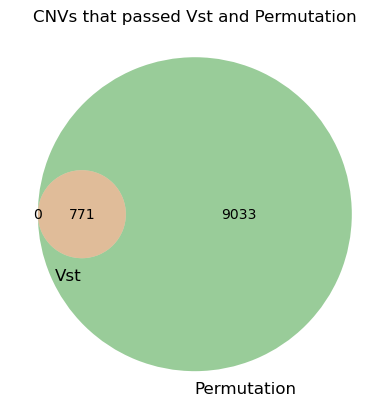

In [199]:
# VST with permutation RESULTS 
inner_vst = len(pd.concat([filtering_vst.T, boolean.T],join='inner', axis=1))
left_vst = len(filtering_vst.T) - inner_vst
right_vst = len(boolean.T) -inner_vst


venn2(subsets = (left_vst, right_vst, inner_vst), set_labels = ('Vst', 'Permutation'))
plt.title('CNVs that passed Vst and Permutation')
plt.show()

In [50]:
cnv_passed_vst = vst_dt.iloc[filtering_vst.columns]
cnv_passed_vst

,CHR,START,END,WestEurasia-Oceania,WestEurasia-America,WestEurasia-Africa,WestEurasia-EastAsia,WestEurasia-SouthAsia,WestEurasia-CentralAsiaSiberia,Oceania-America,...,America-Africa,America-EastAsia,America-SouthAsia,America-CentralAsiaSiberia,Africa-EastAsia,Africa-SouthAsia,Africa-CentralAsiaSiberia,EastAsia-SouthAsia,EastAsia-CentralAsiaSiberia,SouthAsia-CentralAsiaSiberia
0,chr1,102061,111943,0.01834,0.03053,0.10689,0.05349,0.13989,0.04516,0.02785,...,0.22796,0.01875,0.08211,0.02384,0.25003,0.38865,0.27465,0.04123,0.01440,0.06735
5,chr1,1116984,1126261,0.21183,0.01088,0.00891,0.01308,0.01160,0.01197,0.25844,...,0.01640,0.01921,0.01913,0.02360,0.01708,0.01531,0.01743,0.01206,0.01420,0.01544
30,chr1,9337554,9350106,0.02579,0.14029,0.00912,0.02263,0.03687,0.17267,0.08796,...,0.17695,0.08299,0.06437,0.02223,0.03014,0.04744,0.20013,0.01437,0.10290,0.07930
35,chr1,9852641,9861819,0.01044,0.01567,0.05117,0.00841,0.01500,0.13504,0.02827,...,0.08528,0.02112,0.04083,0.21588,0.05627,0.02953,0.04461,0.01869,0.15482,0.10585
52,chr1,12549468,12564684,0.01143,0.14668,0.09757,0.01238,0.02034,0.04428,0.28729,...,0.04949,0.09442,0.16881,0.08743,0.05031,0.12673,0.02490,0.03249,0.02484,0.07591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10736,chrY,24211645,24229764,0.01254,0.02530,0.01480,0.01700,0.03887,0.08079,0.03085,...,0.05317,0.01784,0.09779,0.03571,0.04023,0.02219,0.14081,0.08546,0.05250,0.23520
10737,chrY,24229764,24251349,0.01033,0.02374,0.01560,0.02033,0.03418,0.08528,0.03806,...,0.05531,0.01609,0.08758,0.04065,0.05004,0.01996,0.16229,0.08625,0.05038,0.22429
10738,chrY,24251349,24283859,0.01105,0.01903,0.01661,0.01791,0.04586,0.06881,0.02820,...,0.04302,0.01563,0.08019,0.03485,0.04630,0.02375,0.12686,0.10006,0.04442,0.21254
10740,chrY,25831552,25849672,0.01063,0.02972,0.01627,0.02176,0.03485,0.08566,0.04187,...,0.06571,0.01820,0.10471,0.03462,0.05435,0.01873,0.15970,0.09586,0.05306,0.23563


<h1> Introducing cnvs from old assembly 

In [51]:
cnv_vst_hg19 = pd.read_csv("../data/candidates_574.csv", index_col='Unnamed: 0')
cnv_vst_hg19['start'] = cnv_vst_hg19['start'] +1
cnv_vst_hg19['start'] = cnv_vst_hg19['start'].apply(lambda x: str(x))
cnv_vst_hg19['end'] = cnv_vst_hg19['end'].apply(lambda x: str(x))
cnv_vst_hg19

,chr,start,end,WestEurasia-SouthAsia,WestEurasia-Africa,WestEurasia-CentralAsiaSiberia,WestEurasia-Oceania,WestEurasia-America,WestEurasia-EastAsia,SouthAsia-Africa,...,Africa-CentralAsiaSiberia,Africa-Oceania,Africa-America,Africa-EastAsia,CentralAsiaSiberia-Oceania,CentralAsiaSiberia-America,CentralAsiaSiberia-EastAsia,Oceania-America,Oceania-EastAsia,America-EastAsia
36,1,8359740,8364181,NaN,NaN,0.24315,NaN,0.39153,NaN,NaN,...,0.21795,NaN,0.36120,NaN,NaN,NaN,0.22035,0.31300,NaN,0.36420
37,1,9845437,9863387,NaN,NaN,NaN,NaN,0.26365,NaN,NaN,...,NaN,NaN,0.32252,NaN,NaN,NaN,NaN,0.21695,NaN,NaN
49,1,13725297,13733660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.23619,0.23093,NaN,0.35185,0.34632,NaN,NaN,NaN,NaN
51,1,14436061,14439381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.22469
55,1,16148565,16154830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.23843,NaN,NaN,0.40450,NaN,NaN,NaN,0.31536,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8586,X,146037798,146042345,NaN,0.22866,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8588,X,146360193,146369374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.34919,NaN,NaN
8646,X,154788812,154840186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.30299,NaN,NaN,0.24022,0.25329,NaN
8647,X,154789311,154826421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.30299,NaN,NaN,0.24022,0.25329,NaN


In [52]:
lifover_hg19_chm13 = pd.read_csv("../data/hglft_genome_33223_b1ed30.bed", sep='\t', names=['CHR','START','END','OLD','i']) 
#lifover_hg19_chm13['START'] = lifover_hg19_chm13['START'].apply(lambda x: str(x))
#lifover_hg19_chm13['END'] = lifover_hg19_chm13['END'].apply(lambda x: str(x))
lifover_hg19_chm13[['chr', 'position']] = lifover_hg19_chm13.OLD.str.split(":", expand = True)
lifover_hg19_chm13['chr_num'] = lifover_hg19_chm13['chr'].map(lambda x: x.lstrip('chr').rstrip('aAbBcC'))
lifover_hg19_chm13[['start', 'end']] = lifover_hg19_chm13.position.str.split("-", expand = True)
lifover_hg19_chm13

,CHR,START,END,OLD,i,chr,position,chr_num,start,end
0,chr1,7831416,7835810,chr1:8359740-8364181,1,chr1,8359740-8364181,1,8359740,8364181
1,chr1,9328164,9346113,chr1:9845437-9863387,1,chr1,9845437-9863387,1,9845437,9863387
2,chr1,12840112,12848473,chr1:13725297-13733660,1,chr1,13725297-13733660,1,13725297,13733660
3,chr1,13551736,13555057,chr1:14436061-14439381,1,chr1,14436061-14439381,1,14436061,14439381
4,chr1,15266831,15270191,chr1:16148565-16154830,1,chr1,16148565-16154830,1,16148565,16154830
...,...,...,...,...,...,...,...,...,...,...
695,chrX,153797464,153835748,chrX:154788812-154840186,1,chrX,154788812-154840186,X,154788812,154840186
696,chrX,153847068,153847378,chrX:154788812-154840186,2,chrX,154788812-154840186,X,154788812,154840186
697,chrX,153797963,153821992,chrX:154789311-154826421,1,chrX,154789311-154826421,X,154789311,154826421
698,chrX,153847068,153847378,chrX:154789311-154826421,2,chrX,154789311-154826421,X,154789311,154826421


In [53]:
#cnv_vst_hg19.merge(lifover_hg19_chm13, how='inner', on=['chr,start,end'])
#cnv_passed_vst

cnvs_hg19_overlift = pd.merge(cnv_vst_hg19, lifover_hg19_chm13,  how='inner', left_on=['chr','start','end'], right_on = ['chr_num','start','end'])
cnvs_hg19_overlift

,chr_x,start,end,WestEurasia-SouthAsia,WestEurasia-Africa,WestEurasia-CentralAsiaSiberia,WestEurasia-Oceania,WestEurasia-America,WestEurasia-EastAsia,SouthAsia-Africa,...,Oceania-EastAsia,America-EastAsia,CHR,START,END,OLD,i,chr_y,position,chr_num
0,1,8359740,8364181,NaN,NaN,0.24315,NaN,0.39153,NaN,NaN,...,NaN,0.36420,chr1,7831416,7835810,chr1:8359740-8364181,1,chr1,8359740-8364181,1
1,1,9845437,9863387,NaN,NaN,NaN,NaN,0.26365,NaN,NaN,...,NaN,NaN,chr1,9328164,9346113,chr1:9845437-9863387,1,chr1,9845437-9863387,1
2,1,13725297,13733660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,chr1,12840112,12848473,chr1:13725297-13733660,1,chr1,13725297-13733660,1
3,1,14436061,14439381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.22469,chr1,13551736,13555057,chr1:14436061-14439381,1,chr1,14436061-14439381,1
4,1,16148565,16154830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.31536,NaN,chr1,15266831,15270191,chr1:16148565-16154830,1,chr1,16148565-16154830,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,X,154788812,154840186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.25329,NaN,chrX,153797464,153835748,chrX:154788812-154840186,1,chrX,154788812-154840186,X
696,X,154788812,154840186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.25329,NaN,chrX,153847068,153847378,chrX:154788812-154840186,2,chrX,154788812-154840186,X
697,X,154789311,154826421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.25329,NaN,chrX,153797963,153821992,chrX:154789311-154826421,1,chrX,154789311-154826421,X
698,X,154789311,154826421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.25329,NaN,chrX,153847068,153847378,chrX:154789311-154826421,2,chrX,154789311-154826421,X


<h1> gene anotation

In [84]:
feature_table = pd.read_table('../data/GCF_009914755.1_T2T-CHM13v2.0_feature_table.txt')#, index_col='chromosome')
report = pd.read_table('../data/GCF_009914755.1_T2T-CHM13v2.0_assembly_report.txt')

chm13_gene_anotation = feature_table.merge(report, left_on='genomic_accession', right_on='RefSeq-Accn')
chm13_gene_anotation[chm13_gene_anotation['class'] == 'protein_coding']
gene_anotation = pd.DataFrame()
gene_anotation['CHR_2'] = chm13_gene_anotation['GenBank-Accn']
gene_anotation['START'] = chm13_gene_anotation['start']
gene_anotation['END'] = chm13_gene_anotation['end']
gene_anotation['CHR'] = chm13_gene_anotation['chromosome'] 
gene_anotation['SYMBOL'] = chm13_gene_anotation['symbol'] 
gene_anotation['GENEID'] = chm13_gene_anotation['GeneID'] 
gene_anotation['CHR'] = gene_anotation['CHR'].apply(lambda x: "chr" + str(x))
gene_anotation = gene_anotation.drop_duplicates()
gene_anotation[gene_anotation['SYMBOL'] == 'METTL9']

/var/folders/05/q9klbb6d06d76xy7b8th0xf40000gn/T/ipykernel_11560/1145189376.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  feature_table = pd.read_table('../data/GCF_009914755.1_T2T-CHM13v2.0_feature_table.txt')#, index_col='chromosome')


,CHR_2,START,END,CHR,SYMBOL,GENEID
174108,CP068262.2,22559463,22619737,chr16,METTL9,51108
174111,CP068262.2,22559463,22617368,chr16,METTL9,51108
174113,CP068262.2,22561502,22619689,chr16,METTL9,51108
174115,CP068262.2,22561502,22617211,chr16,METTL9,51108


In [82]:
overlapped = []

cnvs_hg19_overlift_np = gene_anotation.to_numpy()
cnv_passed_vst_np = cnv_passed_vst.to_numpy()

for cnv_q in cnvs_hg19_overlift_np:
    for cnv_c in cnv_passed_vst_np:
    
        if cnv_q[3] == cnv_c[0]: #Chromosome
            # QDNASEQ CNVS in SUDMANT DATA(SUDMANT bigger than  QDNASEQ)
            if (cnv_c[1] <= cnv_q[1] <= cnv_c[2]) or (cnv_c[1] <= cnv_q[2] <= cnv_c[2]):
                #leng_dqna = (cnv_q[3]-cnv_q[2])
                #leng_cnvnator = (cnv_c[2]-cnv_c[1])
                #if (leng_dqna/leng_cnvnator)>0.6:
                overlapped.append([cnv_c[0], cnv_c[1], cnv_c[2], cnv_q[4]])
                    #overlapped.append(cnv_q)
            # SUDMANT DATA CNVS in QDNASEQ CNVs(QDNASEQ bigger than SUDMANT DATA)
            
            if (cnv_q[1] <= cnv_c[1] <= cnv_q[2]) or (cnv_q[1] <= cnv_c[2] <= cnv_q[2]):
                #leng_dq/na = (cnv_q[3]-cnv_q[2])
                #leng_cnvnator = (cnv_c[2]-cnv_c[1])
                #if (leng_cnvnator/leng_dqna)>0.6:
                overlapped.append([cnv_c[0], cnv_c[1], cnv_c[2], cnv_q[4]])
                    #overlapped.append([cnv_q, cnv_c])
                    #overlapped.append(cnv_q)

In [83]:
genes = pd.DataFrame(overlapped).drop_duplicates()
genes.columns = ['CHR', 'START', 'END', 'SYMBOL']
genes.sort_values(by='SYMBOL')

,CHR,START,END,SYMBOL
2349,chrX,73559296,73572104,ABCB7
2348,chrX,73548387,73558296,ABCB7
2347,chrX,73511161,73519353,ABCB7
1151,chr16,15984921,15994087,ABCC1
355,chr4,91497917,91521261,ABCG2
...,...,...,...,...
1862,chrX,47268208,47277659,ZNF81
1861,chrX,47256587,47266355,ZNF81
1864,chrX,47332142,47353700,ZNF81
1863,chrX,47285390,47305657,ZNF81


In [85]:
genes[genes['SYMBOL'] == 'METTL9']

,CHR,START,END,SYMBOL


In [68]:
cnv_passed_vst = genes.merge(cnv_passed_vst)
cnv_passed_vst

,CHR,START,END,SYMBOL,WestEurasia-Oceania,WestEurasia-America,WestEurasia-Africa,WestEurasia-EastAsia,WestEurasia-SouthAsia,WestEurasia-CentralAsiaSiberia,...,America-Africa,America-EastAsia,America-SouthAsia,America-CentralAsiaSiberia,Africa-EastAsia,Africa-SouthAsia,Africa-CentralAsiaSiberia,EastAsia-SouthAsia,EastAsia-CentralAsiaSiberia,SouthAsia-CentralAsiaSiberia
0,chr1,102061,111943,OR4F29,0.01834,0.03053,0.10689,0.05349,0.13989,0.04516,...,0.22796,0.01875,0.08211,0.02384,0.25003,0.38865,0.27465,0.04123,0.01440,0.06735
1,chr1,1116984,1126261,SLC35E2B,0.21183,0.01088,0.00891,0.01308,0.01160,0.01197,...,0.01640,0.01921,0.01913,0.02360,0.01708,0.01531,0.01743,0.01206,0.01420,0.01544
2,chr1,9337554,9350106,CLSTN1,0.02579,0.14029,0.00912,0.02263,0.03687,0.17267,...,0.17695,0.08299,0.06437,0.02223,0.03014,0.04744,0.20013,0.01437,0.10290,0.07930
3,chr1,9852641,9861819,KIF1B,0.01044,0.01567,0.05117,0.00841,0.01500,0.13504,...,0.08528,0.02112,0.04083,0.21588,0.05627,0.02953,0.04461,0.01869,0.15482,0.10585
4,chr1,12549468,12564684,PRAMEF13,0.01143,0.14668,0.09757,0.01238,0.02034,0.04428,...,0.04949,0.09442,0.16881,0.08743,0.05031,0.12673,0.02490,0.03249,0.02484,0.07591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,chrY,24211645,24229764,BPY2B,0.01254,0.02530,0.01480,0.01700,0.03887,0.08079,...,0.05317,0.01784,0.09779,0.03571,0.04023,0.02219,0.14081,0.08546,0.05250,0.23520
860,chrY,24229764,24251349,BPY2B,0.01033,0.02374,0.01560,0.02033,0.03418,0.08528,...,0.05531,0.01609,0.08758,0.04065,0.05004,0.01996,0.16229,0.08625,0.05038,0.22429
861,chrY,24251349,24283859,TTTY4B,0.01105,0.01903,0.01661,0.01791,0.04586,0.06881,...,0.04302,0.01563,0.08019,0.03485,0.04630,0.02375,0.12686,0.10006,0.04442,0.21254
862,chrY,25831552,25849672,BPY2,0.01063,0.02972,0.01627,0.02176,0.03485,0.08566,...,0.06571,0.01820,0.10471,0.03462,0.05435,0.01873,0.15970,0.09586,0.05306,0.23563


<h1> overlapped with hg19

In [69]:
overlapped = []

cnvs_hg19_overlift_np = cnvs_hg19_overlift.to_numpy()
cnv_passed_vst_np = cnv_passed_vst.to_numpy()

for cnv_q in cnvs_hg19_overlift_np:
    for cnv_c in cnv_passed_vst_np:
    
        if cnv_q[-3] == cnv_c[0]: #Chromosome
            # 
            if (cnv_c[1] <= cnv_q[-7] <= cnv_c[2]) or (cnv_c[1] <= cnv_q[-6] <= cnv_c[2]):
                #leng_dqna = (cnv_q[3]-cnv_q[2])
                #leng_cnvnator = (cnv_c[2]-cnv_c[1])
                #if (leng_dqna/leng_cnvnator)>0.6:
                overlapped.append([cnv_q[-8], cnv_q[-7], cnv_q[-6], cnv_c[0], cnv_c[1], cnv_c[2]])
                    #overlapped.append(cnv_q)
            # 
            
            if (cnv_q[-7] <= cnv_c[1] <= cnv_q[-6]) or (cnv_q[-7] <= cnv_c[2] <= cnv_q[-6]):
                #leng_dq/na = (cnv_q[3]-cnv_q[2])
                #leng_cnvnator = (cnv_c[2]-cnv_c[1])
                #if (leng_cnvnator/leng_dqna)>0.6:
                overlapped.append([cnv_q[-8], cnv_q[-7], cnv_q[-6], cnv_c[0], cnv_c[1], cnv_c[2]])
                    #overlapped.append([cnv_q, cnv_c])
                    #overlapped.append(cnv_q)

In [72]:
overlapped_cnvs = pd.DataFrame(overlapped)
overlapped_cnvs = overlapped_cnvs.drop_duplicates()
overlapped_cnvs 

,0,1,2,3,4,5
0,chr1,9328164,9346113,chr1,9337554,9350106
2,chr1,144416713,144500870,chr1,144416000,144502839
3,chr1,147813464,147869168,chr1,147813843,147824531
4,chr1,144467509,144468142,chr1,144416000,144502839
5,chr1,168602793,168640912,chr1,168602705,168615424
7,chr1,168602793,168640912,chr1,168616996,168625289
8,chr11,47189450,47199853,chr11,47189271,47198341
10,chr11,47189450,47199853,chr11,47198341,47207572
16,chr12,8170591,8419854,chr12,8170744,8180936
17,chr14,67731462,67794751,chr14,67767430,67776722


In [74]:
overlapped_cnvs.columns = ['chr', 'start', 'end', 'CHR','START', 'END']
overlapped_cnvs['lenght'] = overlapped_cnvs['end'] - overlapped_cnvs['start']
overlapped_cnvs['LENGHT'] = overlapped_cnvs['END'] - overlapped_cnvs['START']
overlapped_cnvs

,chr,start,end,CHR,START,END,lenght,LENGHT
0,chr1,9328164,9346113,chr1,9337554,9350106,17949,12552
2,chr1,144416713,144500870,chr1,144416000,144502839,84157,86839
3,chr1,147813464,147869168,chr1,147813843,147824531,55704,10688
4,chr1,144467509,144468142,chr1,144416000,144502839,633,86839
5,chr1,168602793,168640912,chr1,168602705,168615424,38119,12719
7,chr1,168602793,168640912,chr1,168616996,168625289,38119,8293
8,chr11,47189450,47199853,chr11,47189271,47198341,10403,9070
10,chr11,47189450,47199853,chr11,47198341,47207572,10403,9231
16,chr12,8170591,8419854,chr12,8170744,8180936,249263,10192
17,chr14,67731462,67794751,chr14,67767430,67776722,63289,9292


In [75]:
cnvs_chm13and_hg19 = overlapped_cnvs.merge(cnv_passed_vst, how='left', on=['CHR', 'START','END'])
cnvs_chm13and_hg19.to_csv('31candidatesfromhg19andchm13.csv')

In [97]:
cnvs_chm13and_hg19.sort_values(by='WestEurasia-Oceania', ascending=False)

,chr,start,end,CHR,START,END,lenght,LENGHT,SYMBOL,WestEurasia-Oceania,...,America-Africa,America-EastAsia,America-SouthAsia,America-CentralAsiaSiberia,Africa-EastAsia,Africa-SouthAsia,Africa-CentralAsiaSiberia,EastAsia-SouthAsia,EastAsia-CentralAsiaSiberia,SouthAsia-CentralAsiaSiberia
21,chr3,117656886,117663013,chr3,117662169,117674357,6127,12188,ZBTB20,0.36589,...,0.24283,0.00000,0.07692,0.00000,0.33312,0.18815,0.27668,0.10391,0.00000,0.08653
27,chr8,23424581,23439842,chr8,23424961,23435696,15261,10735,TNFRSF10D,0.34639,...,0.07859,0.02174,0.00000,0.00000,0.07698,0.10163,0.08916,0.02174,0.02174,0.00000
4,chr1,168602793,168640912,chr1,168602705,168615424,38119,12719,NME7,0.23580,...,0.10981,0.10079,0.23171,0.14815,0.01758,0.02728,0.01767,0.05967,0.01420,0.05171
5,chr1,168602793,168640912,chr1,168616996,168625289,38119,8293,NME7,0.23084,...,0.10823,0.10079,0.21770,0.13556,0.02092,0.02525,0.01614,0.06580,0.01711,0.04034
16,chr2,179676720,179701753,chr2,179688499,179701803,25033,13304,SESTD1,0.12120,...,0.30680,0.08276,0.31081,0.19298,0.15287,0.01273,0.06377,0.14777,0.03715,0.06165
22,chr4,71940842,72129162,chr4,71978928,71991570,188320,12642,UGT2B17,0.11749,...,0.05596,0.11070,0.10197,0.07782,0.24974,0.23519,0.17747,0.01887,0.02051,0.01556
2,chr1,147813464,147869168,chr1,147813843,147824531,55704,10688,NBPF12,0.10803,...,0.05934,0.08749,0.04344,0.13980,0.20843,0.15402,0.26197,0.05367,0.01651,0.06119
3,chr1,144467509,144468142,chr1,144416000,144502839,633,86839,NBPF20,0.10640,...,0.06280,0.09454,0.04120,0.13886,0.22446,0.15324,0.26005,0.06072,0.01760,0.06293
1,chr1,144416713,144500870,chr1,144416000,144502839,84157,86839,NBPF20,0.10640,...,0.06280,0.09454,0.04120,0.13886,0.22446,0.15324,0.26005,0.06072,0.01760,0.06293
24,chr5,179511134,179518155,chr5,179504008,179516826,7021,12818,ZNF454,0.07896,...,0.04121,0.13043,0.03571,0.14815,0.09522,0.01441,0.07983,0.11249,0.01598,0.10096


In [96]:
cnv_passed_vst.sort_values(by=['America-Africa', 'START'],ascending=False).head(50)



,CHR,START,END,SYMBOL,WestEurasia-Oceania,WestEurasia-America,WestEurasia-Africa,WestEurasia-EastAsia,WestEurasia-SouthAsia,WestEurasia-CentralAsiaSiberia,...,America-Africa,America-EastAsia,America-SouthAsia,America-CentralAsiaSiberia,Africa-EastAsia,Africa-SouthAsia,Africa-CentralAsiaSiberia,EastAsia-SouthAsia,EastAsia-CentralAsiaSiberia,SouthAsia-CentralAsiaSiberia
222,chr12,92893755,92902894,EEA1,0.29638,0.25915,0.09728,0.29955,0.13403,0.24109,...,0.53035,0.01947,0.09009,0.03833,0.53662,0.35692,0.50858,0.06490,0.01542,0.05355
252,chr15,18965024,18975815,LINC02203,0.09162,0.21625,0.07015,0.01597,0.04442,0.06550,...,0.47126,0.32788,0.40898,0.13558,0.04066,0.01580,0.23525,0.02407,0.12073,0.18598
254,chr15,18965024,18975815,OR4M2-OT1,0.09162,0.21625,0.07015,0.01597,0.04442,0.06550,...,0.47126,0.32788,0.40898,0.13558,0.04066,0.01580,0.23525,0.02407,0.12073,0.18598
255,chr15,18965024,18975815,LOC124903610,0.09162,0.21625,0.07015,0.01597,0.04442,0.06550,...,0.47126,0.32788,0.40898,0.13558,0.04066,0.01580,0.23525,0.02407,0.12073,0.18598
110,chr5,178296679,178305087,FAM153A,0.02712,0.12306,0.02040,0.10055,0.00910,0.06230,...,0.46000,0.02624,0.24628,0.05251,0.27450,0.06947,0.27267,0.14214,0.01764,0.11482
251,chr15,18921721,18935311,LINC02203,0.11843,0.20583,0.04213,0.00849,0.01790,0.10906,...,0.45384,0.27343,0.42400,0.10622,0.05353,0.02334,0.29146,0.02460,0.13448,0.23922
253,chr15,18921721,18935311,OR4M2-OT1,0.11843,0.20583,0.04213,0.00849,0.01790,0.10906,...,0.45384,0.27343,0.42400,0.10622,0.05353,0.02334,0.29146,0.02460,0.13448,0.23922
262,chr16,11954846,11963997,NPIPB2,0.02423,0.19646,0.11287,0.07608,0.07548,0.18122,...,0.44878,0.01522,0.08236,0.02483,0.15529,0.28300,0.42144,0.02395,0.01386,0.05823
267,chr16,21675562,21683858,LOC105371131,0.01033,0.27776,0.06414,0.10059,0.09100,0.22594,...,0.44279,0.01606,0.13717,0.03695,0.15206,0.23072,0.38364,0.03076,0.01398,0.07577
268,chr16,21675562,21683858,NPIPB3,0.01033,0.27776,0.06414,0.10059,0.09100,0.22594,...,0.44279,0.01606,0.13717,0.03695,0.15206,0.23072,0.38364,0.03076,0.01398,0.07577


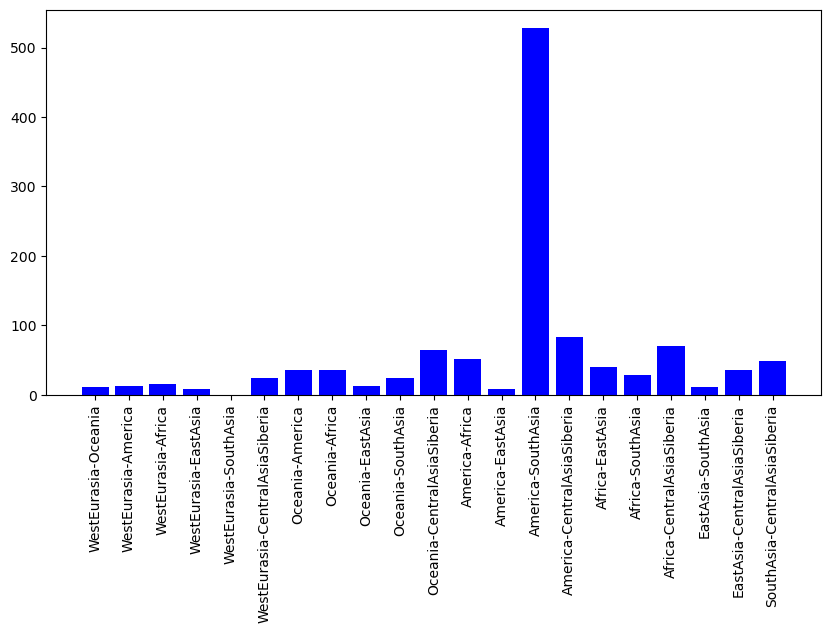

In [99]:
vst_fivehund = filtering_vst.T 
dist = vst_fivehund.sum()

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(dist.index, dist, color ='blue')
 
#plt.xlabel("Pairwise combination")
#plt.ylabel("# of CNVs passed perrmutation")
#plt.title("CNVs that passed Vst(pair-group) and permutation", size=20)
plt.xticks(rotation=90)
plt.savefig('../plots/distribution_864candidates_chm13.png', transparent=True)
plt.show()


In [95]:
cnv_passed_vst.sort_values(by=['America-SouthAsia', 'START'],ascending=False)

,CHR,START,END,SYMBOL,WestEurasia-Oceania,WestEurasia-America,WestEurasia-Africa,WestEurasia-EastAsia,WestEurasia-SouthAsia,WestEurasia-CentralAsiaSiberia,...,America-Africa,America-EastAsia,America-SouthAsia,America-CentralAsiaSiberia,Africa-EastAsia,Africa-SouthAsia,Africa-CentralAsiaSiberia,EastAsia-SouthAsia,EastAsia-CentralAsiaSiberia,SouthAsia-CentralAsiaSiberia
251,chr15,18921721,18935311,LINC02203,0.11843,0.20583,0.04213,0.00849,0.01790,0.10906,...,0.45384,0.27343,0.42400,0.10622,0.05353,0.02334,0.29146,0.02460,0.13448,0.23922
253,chr15,18921721,18935311,OR4M2-OT1,0.11843,0.20583,0.04213,0.00849,0.01790,0.10906,...,0.45384,0.27343,0.42400,0.10622,0.05353,0.02334,0.29146,0.02460,0.13448,0.23922
252,chr15,18965024,18975815,LINC02203,0.09162,0.21625,0.07015,0.01597,0.04442,0.06550,...,0.47126,0.32788,0.40898,0.13558,0.04066,0.01580,0.23525,0.02407,0.12073,0.18598
254,chr15,18965024,18975815,OR4M2-OT1,0.09162,0.21625,0.07015,0.01597,0.04442,0.06550,...,0.47126,0.32788,0.40898,0.13558,0.04066,0.01580,0.23525,0.02407,0.12073,0.18598
255,chr15,18965024,18975815,LOC124903610,0.09162,0.21625,0.07015,0.01597,0.04442,0.06550,...,0.47126,0.32788,0.40898,0.13558,0.04066,0.01580,0.23525,0.02407,0.12073,0.18598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,chr12,52070882,52082361,OR7E47P,0.01181,0.01664,0.05896,0.06950,0.01823,0.06171,...,0.10606,0.04035,0.01728,0.06484,0.17843,0.12435,0.21971,0.04338,0.01599,0.05245
220,chr12,52070882,52082361,LOC112268096,0.01181,0.01664,0.05896,0.06950,0.01823,0.06171,...,0.10606,0.04035,0.01728,0.06484,0.17843,0.12435,0.21971,0.04338,0.01599,0.05245
89,chr4,72079101,72088338,UGT2B15,0.02006,0.03312,0.01683,0.13033,0.03641,0.10476,...,0.09213,0.05391,0.01725,0.06041,0.22139,0.08664,0.20341,0.05162,0.01374,0.04912
165,chr9,78693375,78701752,ZNF658,0.01156,0.01671,0.00947,0.03195,0.01655,0.17068,...,0.03098,0.04847,0.01724,0.21576,0.02730,0.02780,0.16135,0.05555,0.06379,0.23508


In [98]:
cnv_passed_vst[cnv_passed_vst.SYMBOL =='TBC1D3']

,CHR,START,END,SYMBOL,WestEurasia-Oceania,WestEurasia-America,WestEurasia-Africa,WestEurasia-EastAsia,WestEurasia-SouthAsia,WestEurasia-CentralAsiaSiberia,...,America-Africa,America-EastAsia,America-SouthAsia,America-CentralAsiaSiberia,Africa-EastAsia,Africa-SouthAsia,Africa-CentralAsiaSiberia,EastAsia-SouthAsia,EastAsia-CentralAsiaSiberia,SouthAsia-CentralAsiaSiberia
